In [99]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import random
from torch.autograd import Variable

In [52]:
def generate_data(n_samples_1, n_samples_2, noise_level, seed=15, display=False):
    n_samples_1, n_samples_3 = int(n_samples_1 / 2), int(n_samples_1 / 2)
    n_samples_2, n_samples_4 = int(n_samples_2 / 2), int(n_samples_2 / 2)
    centers = [[0.0, 0.0], [0.0, 1.5], [1.5, 1.5], [1.5, 0.0]]
    clusters_std = [0.4, 0.4, 0.4, 0.4]
    X, y = make_blobs(n_samples=[n_samples_1, n_samples_2, n_samples_3, n_samples_4],
                      centers=centers,
                      cluster_std=clusters_std,
                      random_state = 15,
                      shuffle=False)
    
    # Add x1 * x2 to data
    nonlinearity = X[:, 0] * X[:, 1]
    nonlinearity = nonlinearity[:, None]
    X = np.hstack((X, nonlinearity))
    
    # Set diagnoals to be the same class
    y = y % 2
    
    # Split into train, test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    
    # Create 1:9 majority:minority class imbalance for training data
    class_0_idxs = np.where(y_train == 0)[0] # Majority class
    class_1_idxs = np.where(y_train == 1)[0] # Minority class
    new_class_0_size = len(class_1_idxs) // 9
    new_class_0_idxs = np.random.choice(class_0_idxs, new_class_0_size)
    new_idxs = list(new_class_0_idxs) + list(class_1_idxs)
    X_train = X_train[new_idxs]
    y_train = y_train[new_idxs]
    
    # Randomly flip a percentage of training labels
    n = len(y_train)
    y_train = np.array([abs(1 - y_train[i]) if i in random.sample(range(n), int(noise_level * n)) else y_train[i] for i in range(n)])

    if display:
#         plt.scatter(X_train[:,0], X_train[:,1], c=['#516091' if y==1 else '#A9ECA2' for y in y_train])
#         plt.savefig('class_imbalance_train_5_percent_noise.png')
        plt.scatter(X_test[:,0], X_test[:,1], c=['#516091' if y==1 else '#A9ECA2' for y in y_test])
    
    y_train = y_train.reshape(-1, 1)
    X_train = torch.tensor(X_train, dtype=torch.float)
    y_train = torch.tensor(y_train, dtype=torch.float)
    
    y_test = y_test.reshape(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float)
    y_test = torch.tensor(y_test, dtype=torch.float)
    
    return X_train, X_test, y_train, y_test

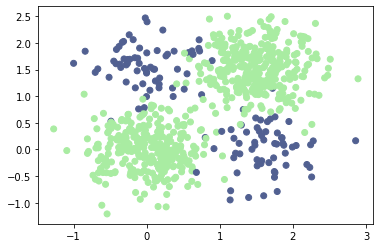

In [53]:
X_train, X_test, y_train, y_test = generate_data(2000, 400, 0.05, display=True)

In [35]:
import sys
sys.path.insert(0, '/Users/william/Documents/CMU/Research/RiskSensitiveLearning/SupervisedLearning/objectives')
import cvar, human_aligned_risk, entropic_risk, trimmed_risk, mean_variance

In [36]:
input_size = 3
output_size = 2

class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        return x

learning_rate = 1e-2

In [37]:
def eval_under_objective(model, X, y, objective):
    model.eval()
    with torch.no_grad():
        output = model(X)
        loss = objective(output, y.squeeze(1).type(torch.LongTensor))
    return loss.item()

In [65]:
def colorFader(c1, c2, levels=20):
    c1 = np.array(mpl.colors.to_rgb(c1))
    c2 = np.array(mpl.colors.to_rgb(c2))
    alphas = np.linspace(0, 1, levels)
    return [mpl.colors.to_hex((1 - a) * c1 + a * c2) for a in alphas]

def plot_decision_boundary(model, X, y, objective_name, fname, plot_points=False):
    # define the x and y scale
    x1grid = np.arange(X[:, 0].min() - 1, X[:, 0].max() + 1, 0.1)
    x2grid = np.arange(X[:, 1].min(), X[:, 1].max() + 1, 0.1)

    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1, r2, r1*r2))

    pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
    pred = pred.detach().numpy()

    # keep probabilities for class 0
    pred = pred[:, 0]
    # reshape the predictions back into a grid
    zz = pred.reshape(xx.shape)

    # plot the grid of x, y and z values as a surface
    levels = 7
    c = plt.contourf(xx, yy, zz, levels=levels, colors=colorFader('#516091', '#a9eca2', levels+2))
    # add a legend, called a color bar
    plt.colorbar(c)
    
    if plot_points:
        plt.scatter(X[:,0], X[:,1], c=['#516091' if label==1 else '#A9ECA2' for label in y], alpha=0.5, edgecolors='black')
    
    path = 'class_imbalance/decision_boundaries/' + objective_name + '/'
    os.makedirs(path, exist_ok=True)
    plt.savefig(path + fname + '.png')
    
    plt.close()

In [66]:
def plot_loss_distribution(losses, path, objective_name, fname):
    plt.figure(figsize=(10,6))
    
    weights = np.ones_like(losses) / len(losses)
    bins = np.linspace(0, 5, 50)
    n, bins, patches = plt.hist(x=losses, bins=bins, color='#272f4a',
                            alpha=1, weights=weights)
    
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Cross Entropy Loss')
    plt.ylabel('Percent of Samples')
    plt.xlim(0, 5)
    plt.ylim(0, 1)
    plt.xticks(np.arange(0, 5.1, 0.5))

    os.makedirs(path, exist_ok=True)
    plt.savefig(path + fname + '.png')
    
    plt.close()

In [67]:
seeds = [i for i in range(10)]
noises = [0]
objectives = {
    'Expected Value': nn.CrossEntropyLoss(),
    'CVaR': cvar.CVaR(a=0.1), # We look at bottom alpha% of losses
    'Entropic Risk': entropic_risk.EntropicRisk(t=10),
    'Human-Aligned Risk': human_aligned_risk.HumanAlignedRisk(a=0.4, b=0.3),
    'Inverted CVaR': cvar.CVaR(a=0.9, inverted=True), # We look at top alpha% of losses
    'Mean-Variance': mean_variance.MeanVariance(c=1),
    'Trimmed Risk': trimmed_risk.TrimmedRisk(a=0.1),
}
eval_objectives = {
    'Expected Value': nn.CrossEntropyLoss(),
    'CVaR': cvar.CVaR(a=0.1), # We look at bottom alpha% of losses
    'Entropic Risk': entropic_risk.EntropicRisk(t=10),
    'Human-Aligned Risk': human_aligned_risk.HumanAlignedRisk(a=0.4, b=0.3),
    'Inverted CVaR': cvar.CVaR(a=0.9, inverted=True), # We look at top alpha% of losses
    'Mean-Variance': mean_variance.MeanVariance(c=1),
    'Trimmed Risk': trimmed_risk.TrimmedRisk(a=0.1),
}

metrics = {}

for objective in objectives.keys():
    metrics[objective + '_train'] = dict()
    metrics[objective + '_test'] = dict()
    for noise in noises:
        metrics[objective + '_train']['accuracy_noise=' + str(noise)] = []
        metrics[objective + '_test']['accuracy_noise=' + str(noise)] = []
        metrics[objective + '_train']['epochs_noise=' + str(noise)] = []
        metrics[objective + '_test']['majorityaccuracy_noise=' + str(noise)] = []
        metrics[objective + '_test']['minorityaccuracy_noise=' + str(noise)] = []
        
        train_losses = []
        test_losses = []
        
        for seed in seeds:
            X_train, X_test, y_train, y_test = generate_data(2000, 400, 0, seed=seed)

            # Get objective
            criterion = objectives[objective]

            # Reset random seeds for comparaison.
            torch.manual_seed(seed)
            random.seed(seed)
            np.random.seed(seed)

            model = LogisticRegression(input_size, output_size)
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

            epochs = 0
            converged = False
            loss_buffer = []
            while not converged:
                # Train
                model.train()
                epochs += 1
                optimizer.zero_grad()

                output = model(X_train)
                loss = criterion(output, y_train.squeeze(1).type(torch.LongTensor))

                loss.backward()
                optimizer.step()
                
                loss_buffer.append(loss.item())
                # Let convergence criterion be if current risk is within the average of past 20 risks by 1e-3
                if len(loss_buffer) > 20:
                    loss_buffer.pop(0)
                    converged = abs(loss.item() - np.mean(loss_buffer)) <= 1e-3
                else:
                    converged = False

            model.eval()
            
            # Save decision boundary visualization for train data
            boundary_fname = objective + '_train_noise=' + str(noise) + '_seed=' + str(seed)
            plot_decision_boundary(model, X_train, y_train, objective, boundary_fname, plot_points=True)

            # Save decision boundary visualization for test data
            boundary_fname = objective + '_test_noise=' + str(noise) + '_seed=' + str(seed)
            plot_decision_boundary(model, X_test, y_test, objective, boundary_fname, plot_points=True)
            
            # Save final training loss distribution under cross entropy objective
            distribution_criterion = nn.CrossEntropyLoss(reduction='none')
            train_losses.extend(distribution_criterion(output, y_train.squeeze(1).type(torch.LongTensor)).detach().numpy())

            for eval_objective in eval_objectives.keys():
                if eval_objective + '_noise=' + str(noise) not in metrics[objective + '_train']:
                    metrics[objective + '_train'][eval_objective + '_noise=' + str(noise)] = []
                if eval_objective + '_noise=' + str(noise) not in metrics[objective + '_test']:
                    metrics[objective + '_test'][eval_objective + '_noise=' + str(noise)] = []
                # Evaluate under training data
                metrics[objective + '_train'][eval_objective + '_noise=' + str(noise)].append(eval_under_objective(model, X_train, y_train, eval_objectives[eval_objective]))
                # Evaluate under test data
                metrics[objective + '_test'][eval_objective + '_noise=' + str(noise)].append(eval_under_objective(model, X_test, y_test, eval_objectives[eval_objective]))
                        
            # Evaluate test accuracy
            with torch.no_grad():
                # Final train accuracy
                output = model(X_train)
                pred = torch.argmax(F.softmax(output, dim=1), dim=1)
                overall_acc = sum(1 for p, y in zip(pred, y_train) if p == y) / len(pred)
                metrics[objective + '_train']['accuracy_noise=' + str(noise)].append(overall_acc)
                
                # Test accuracy
                output = model(X_test)
                pred = torch.argmax(F.softmax(output, dim=1), dim=1)
                overall_acc = sum(1 for p, y in zip(pred, y_test) if p == y) / len(pred)
                metrics[objective + '_test']['accuracy_noise=' + str(noise)].append(overall_acc)
                
                majority_idxs = torch.where(y_test == 0)[0]
                minority_idxs = torch.where(y_test == 1)[1]

                majority_acc = sum(1 for x, y in zip(pred[majority_idxs], y_test[majority_idxs]) if x == y) / len(pred[majority_idxs])
                minority_acc = sum(1 for x, y in zip(pred[minority_idxs], y_test[minority_idxs]) if x == y) / len(pred[minority_idxs])

                metrics[objective + '_test']['majorityaccuracy_noise=' + str(noise)].append(majority_acc)
                metrics[objective + '_test']['minorityaccuracy_noise=' + str(noise)].append(minority_acc)
                
            # Save test loss distribution under cross entropy objective
            test_losses.extend(distribution_criterion(output, y_test.squeeze(1).type(torch.LongTensor)).detach().numpy())
            
            # Record number of epochs till convergence
            metrics[objective + '_train']['epochs_noise=' + str(noise)].append(epochs)

        # Plot cumulative train loss distributions
        path = 'class_imbalance/loss_distributions/train/' + objective + '/'
        distribution_fname = objective + '_train_noise=' + str(noise)
        plot_loss_distribution(np.array(train_losses).flatten(), path, objective, distribution_fname)
        
        # Plot cumulative test loss distributions
        path = 'class_imbalance/loss_distributions/test/' + objective + '/'
        distribution_fname = objective + '_test_noise=' + str(noise)
        plot_loss_distribution(np.array(test_losses).flatten(), path, objective, distribution_fname)    

        majority_acc = np.mean(metrics[objective + '_test']['majorityaccuracy_noise=' + str(noise)])
        minority_acc = np.mean(metrics[objective + '_test']['minorityaccuracy_noise=' + str(noise)])
        overall_acc = np.mean(metrics[objective + '_test']['accuracy_noise=' + str(noise)])
        print('Objective: {}, Noise: {}, Majority Accuracy: {}, Minority Accuracy: {}, Overall Accuracy: {}\n'.format(objective, noise, majority_acc, minority_acc, overall_acc))

Objective: Expected Value, Noise: 0, Majority Accuracy: 0.3198639974923028, Minority Accuracy: 0.1, Overall Accuracy: 0.4345833333333333

Objective: CVaR, Noise: 0, Majority Accuracy: 0.7349271703775817, Minority Accuracy: 0.8, Overall Accuracy: 0.7777777777777779

Objective: Entropic Risk, Noise: 0, Majority Accuracy: 0.7390879569398032, Minority Accuracy: 0.8, Overall Accuracy: 0.7808333333333334

Objective: Human-Aligned Risk, Noise: 0, Majority Accuracy: 0.5715588721167418, Minority Accuracy: 0.7, Overall Accuracy: 0.6433333333333333

Objective: Inverted CVaR, Noise: 0, Majority Accuracy: 0.009858857725642163, Minority Accuracy: 0.1, Overall Accuracy: 0.17680555555555555

Objective: Mean-Variance, Noise: 0, Majority Accuracy: 0.5859847102317485, Minority Accuracy: 0.7, Overall Accuracy: 0.6551388888888889

Objective: Trimmed Risk, Noise: 0, Majority Accuracy: 0.00852902378968301, Minority Accuracy: 0.1, Overall Accuracy: 0.17569444444444443



In [101]:
train_keys = []
test_keys = []
for key in metrics.keys():
    if key.split('_')[1] == 'train':
        train_keys.append(key)
    else:
        test_keys.append(key)

In [102]:
order = ['Expected Value', 'CVaR', 'Entropic Risk', 'Human-Aligned Risk', 'Inverted CVaR', 'Mean-Variance', 'Trimmed Risk']
for noise in noises:
    latex_data = dict()
    for i in range(len(order)):
        latex_data[order[i]] = dict()
        
    for objective in train_keys:
        print('\nObjective:', objective)

        metric_keys = metrics[objective].keys()

        for metric_key in metric_keys:
            
            if metric_key.split('_')[0] in order and metric_key.split('=')[1] == str(noise):
                mean = np.mean(metrics[objective][metric_key])
                latex_data[metric_key.split('_')[0]][objective.split('_')[0]] = mean
                print(metric_key, mean)

    latex = ''
    for objective in order:
        latex += '\n' + objective + ' & ' + str(noise) + ' & '
        for i in range(len(order)):
            value = latex_data[order[i]][objective]
            if value == min(latex_data[objective].values()):
                latex += '\\textbf{' + str(round(value, 2)) + '}'
            else:
                latex += str(round(value, 2))
            if i < len(latex_data[order[i]]) - 1:
                latex += ' & '
            else:
                latex += ' \\\\'
    print(latex)


Objective: Expected Value_train
Expected Value_noise=0 0.1560552328824997
CVaR_noise=0 1.0914737462997437
Entropic Risk_noise=0 1.887485182285309
Human-Aligned Risk_noise=0 0.29958930760622027
Inverted CVaR_noise=0 0.05368819609284401
Mean-Variance_noise=0 0.2906849443912506
Trimmed Risk_noise=0 0.0608015276491642

Objective: CVaR_train
Expected Value_noise=0 0.4168734088540077
CVaR_noise=0 0.6545831978321075
Entropic Risk_noise=0 0.5860678374767303
Human-Aligned Risk_noise=0 0.440669184923172
Inverted CVaR_noise=0 0.39036853015422823
Mean-Variance_noise=0 0.4340726315975189
Trimmed Risk_noise=0 0.4128035634756088

Objective: Entropic Risk_train
Expected Value_noise=0 0.40731239318847656
CVaR_noise=0 0.6676375091075897
Entropic Risk_noise=0 0.5233938068151474
Human-Aligned Risk_noise=0 0.43106692731380464
Inverted CVaR_noise=0 0.3782849103212357
Mean-Variance_noise=0 0.42774270474910736
Trimmed Risk_noise=0 0.40529975593090056

Objective: Human-Aligned Risk_train
Expected Value_noise=

In [100]:
order = ['accuracy', 'Expected Value', 'CVaR', 'Entropic Risk', 'Human-Aligned Risk', 'Inverted CVaR', 'Mean-Variance', 'Trimmed Risk']
for noise in noises:
    latex_data = dict()
    for i in range(len(order)):
        latex_data[order[i]] = dict()
        
    for objective in test_keys:
        print('\nObjective:', objective)

        metric_keys = metrics[objective].keys()

        for metric_key in metric_keys:
            
            if metric_key.split('_')[0] in order and metric_key.split('=')[1] == str(noise):
                mean = np.mean(metrics[objective][metric_key])
                latex_data[metric_key.split('_')[0]][objective.split('_')[0]] = mean
                print(metric_key, mean)

    latex = ''
    for objective in order[1:]:
        latex += '\n' + objective + ' & ' + str(noise) + ' & '
        for i in range(1, len(order)):
            value = latex_data[order[i]][objective]
            if value == min(latex_data[order[i]].values()):
                latex += '\\textbf{' + str(round(value, 2)) + '}'
            else:
                latex += str(round(value, 2))
            if i < len(latex_data[order[i]]):
                latex += ' & '
            else:
                latex += ' \\\\'
    print(latex)


Objective: Expected Value_test
accuracy_noise=0 0.4345833333333333
Expected Value_noise=0 0.9278053164482116
CVaR_noise=0 2.2174914598464968
Entropic Risk_noise=0 2.9159740447998046
Human-Aligned Risk_noise=0 1.099865162372589
Inverted CVaR_noise=0 0.7849572002887726
Mean-Variance_noise=0 1.4647336840629577
Trimmed Risk_noise=0 0.88269082903862

Objective: CVaR_test
accuracy_noise=0 0.7777777777777779
Expected Value_noise=0 0.5556368410587311
CVaR_noise=0 0.8751880824565887
Entropic Risk_noise=0 0.8317274212837219
Human-Aligned Risk_noise=0 0.5876793742179871
Inverted CVaR_noise=0 0.5202525198459625
Mean-Variance_noise=0 0.5986403584480285
Trimmed Risk_noise=0 0.553313809633255

Objective: Entropic Risk_test
accuracy_noise=0 0.7808333333333334
Expected Value_noise=0 0.5380982756614685
CVaR_noise=0 0.8416725873947144
Entropic Risk_noise=0 0.7140997111797333
Human-Aligned Risk_noise=0 0.5637395501136779
Inverted CVaR_noise=0 0.504476448893547
Mean-Variance_noise=0 0.5717446744441986
Tri

# CVaR Optimization Comparisons

In [68]:
def plot_loss_curve(losses, path, fname):
    plt.plot(losses)

    os.makedirs(path, exist_ok=True)
    plt.savefig(path + fname + '.png')
    
    plt.close()

## ERM

In [73]:
seeds = [i for i in range(10)]
noises = [0]

alpha = 0.1

objectives = {
    'CVaR': cvar.CVaR(a=alpha), # We look at worst alpha% of losses
}

for objective in objectives.keys():
    losses = []
    test_cvars = []
    train_cvars = []
    cvars = []
    accs = []
    for noise in noises:
        for seed in seeds:
            X_train, X_test, y_train, y_test = generate_data(2000, 400, 0, seed=seed)
            # Get objective
            criterion = objectives[objective]

            # Reset random seeds for comparaison.
            torch.manual_seed(seed)
            random.seed(seed)
            np.random.seed(seed)

            model = LogisticRegression(input_size, output_size)
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

            # Train
            model.train()
            
            losses = []
            convergence_losses = []
            converged = False
            while not converged:
                optimizer.zero_grad()

                output = model(X_train)
                loss = criterion(output, y_train.squeeze(1).type(torch.LongTensor))
                
                cvar_criterion = cvar.CVaR(a=alpha)
                train_output = model(X_train)
                convergence_losses.append(cvar_criterion(train_output, y_train.squeeze(1).type(torch.LongTensor)).item())
                losses.append(loss.item())
                
                # Let convergence criterion be if current loss is within the average of past 20 gradients by 1e-3
                if len(convergence_losses) > 20:
                    converged = abs(loss.item() - np.mean(convergence_losses[-20:])) <= 1e-3
                else:
                    converged = False
                
                loss.backward()
                optimizer.step()
                
            path = 'class_imbalance/cvar_loss_curves/' + objective + '/'
            fname = 'noise=' + str(noise) + '_seed=' + str(seed)
            plot_loss_curve(losses, path, fname)

            # Evaluate
            model.eval()

            cvar_criterion = cvar.CVaR(a=alpha)

            with torch.no_grad():
                train_output = model(X_train)
                train_cvars.append(cvar_criterion(train_output, y_train.squeeze(1).type(torch.LongTensor)))
                
                test_output = model(X_test)
                test_cvars.append(cvar_criterion(test_output, y_test.squeeze(1).type(torch.LongTensor)))
                
        print('Objective: {}, Noise: {}, Average Train CVaR: {}, Average Test CVaR: {}'.format(objective, noise, np.mean(train_cvars), np.mean(test_cvars)))

Objective: CVaR, Noise: 0, Average Train CVaR: 0.654583215713501, Average Test CVaR: 0.8751880526542664


## Trunc-CVaR

In [104]:
seeds = [i for i in range(10)]
noises = [0]

alpha = 0.1

objectives = {
    'Trunc-CVaR': nn.CrossEntropyLoss(reduction='none')
}

for objective in objectives.keys():
    losses = []
    test_cvars = []
    train_cvars = []
    cvars = []
    accs = []
    for noise in noises:
        for seed in seeds:
            X_train, X_test, y_train, y_test = generate_data(2000, 400, 0, seed=seed)
            # Get objective
            criterion = objectives[objective]

            # Reset random seeds for comparaison.
            torch.manual_seed(seed)
            random.seed(seed)
            np.random.seed(seed)

            model = LogisticRegression(input_size, output_size)
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

            eta = 0
            eta_lr = 1e-2
            eta = Variable(torch.zeros(1), requires_grad=True)

            # Train
            model.train()
            
            losses = []
            convergence_losses = []
            converged = False
            while not converged:
                optimizer.zero_grad()

                output = model(X_train)

                loss_eta = criterion(output, y_train.squeeze(1).type(torch.LongTensor)) - eta
                loss = (1 / alpha) * torch.mean(torch.relu(loss_eta)) + eta
                
                cvar_criterion = cvar.CVaR(a=alpha)
                train_output = model(X_train)
                losses.append(cvar_criterion(train_output, y_train.squeeze(1).type(torch.LongTensor)).item())
                convergence_losses.append(loss.item())

                # calculate gradient
                loss.backward(retain_graph=True)
                
                # Let convergence criterion be if current loss is within the average of past 20 gradients by 1e-3
                if len(convergence_losses) > 20:
#                     print(i, loss.item(), abs(loss.item() - np.mean(convergence_losses[-20:])))
                    converged = abs(loss.item() - np.mean(convergence_losses[-20:])) <= 1e-3
                else:
                    converged = False

                # gradient descent
                optimizer.step()
                
                # Update eta
                eta.data -= eta_lr * eta.grad.data

                # Clear variable gradients
                eta.grad.data.zero_()
                
            path = 'class_imbalance/cvar_loss_curves/' + objective + '/'
            fname = 'noise=' + str(noise) + '_seed=' + str(seed)
            plot_loss_curve(losses, path, fname)

            # Save decision boundary visualizations
            boundary_fname = objective + '_train_noise=' + str(noise) + '_seed=' + str(seed)
            plot_decision_boundary(model, X_train, y_train, objective, boundary_fname, plot_points=True)
            boundary_fname = objective + '_test_noise=' + str(noise) + '_seed=' + str(seed)
            plot_decision_boundary(model, X_test, y_test, objective, boundary_fname, plot_points=True)
            
            # Evaluate
            model.eval()

            cvar_criterion = cvar.CVaR(a=alpha)

            with torch.no_grad():
                train_output = model(X_train)
                train_cvars.append(cvar_criterion(train_output, y_train.squeeze(1).type(torch.LongTensor)))
                
                test_output = model(X_test)
                test_cvars.append(cvar_criterion(test_output, y_test.squeeze(1).type(torch.LongTensor)))
                
        print('Objective: {}, Noise: {}, Average Train CVaR: {}, Average Test CVaR: {}'.format(objective, noise, np.mean(train_cvars), np.mean(test_cvars)))

Objective: Trunc-CVaR, Noise: 0, Average Train CVaR: 0.6337876915931702, Average Test CVaR: 1.021315097808838


## Adaptive Sampling

In [ ]:
import sys
sys.path.insert(0, '/Users/william/Documents/CMU/Research/RiskSensitiveLearning/SupervisedLearning/optimizers')

from adacvar.adacvar.util.cvar import CVaR as ada_CVaR
from adacvar.adacvar.util.cvar import SoftCVaR
from adacvar.adacvar.util.adaptive_algorithm import Exp3Sampler
from torch.utils.data import Dataset, DataLoader
from adacvar.adacvar.util.learning_rate_decay import AdaGrad, Constant, RobbinsMonro

class NoisyLabelDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], idx
    
def get_adaptive_algorithm(is_adaptive, dataset, alpha, bsz, eta, gamma=0, beta=0, eps=0):
    num_points = len(dataset)
    
    if is_adaptive:
        iid_batch = False
    else:
        eta = 0
        gamma = 0
        beta = 0
        eps = 1e-16
        iid_batch = True
        
    exp3 = Exp3Sampler(
            batch_size=bsz,
            num_actions=num_points,
            size=int(np.ceil(alpha * num_points)),
            eta=eta,
            gamma=gamma,
            beta=beta,
            eps=eps,
            iid_batch=iid_batch,
        )
    loader = DataLoader(dataset, batch_sampler=exp3)
    return loader, loader.batch_sampler

In [103]:
alpha = 0.1
# Try alpha = 1 or don't update weights/uniform weights
seeds = [i for i in range(10)]
noises = [0]

objectives = {
    'Adaptive Sampling': ada_CVaR(alpha=1, learning_rate=0),
    'AdaVar Mean': ada_CVaR(alpha=1, learning_rate=0),
    'AdaVar Trunc CVaR': ada_CVaR(alpha=alpha, learning_rate=1e-2),
    'Soft CVaR': SoftCVaR(alpha=alpha, learning_rate=1e-2, temperature=1.0)
}

for objective in objectives.keys():
    losses = []
    test_cvars = []
    train_cvars = []
    accs = []
    for noise in noises:
        for seed in seeds:
            X_train, X_test, y_train, y_test = generate_data(2000, 400, 0, seed=seed)
            # Get CVaR Objective
            cvar_train_obj = objectives[objective]
            criterion = nn.CrossEntropyLoss(reduction='none')

            # Reset random seeds for comparaison.
            torch.manual_seed(seed)
            random.seed(seed)
            np.random.seed(seed)

            model = LogisticRegression(input_size, output_size)
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
            scheduler = torch.optim.lr_scheduler.MultiStepLR(
                optimizer, [20, 40], gamma=1.0, last_epoch=-1
            )

#             exp3_lr = np.sqrt(1 / alpha * np.log(1 / alpha))
#             exp3_lr = 1
            exp3_lr = RobbinsMonro(0.5, len(X_train))
#             exp3_lr = AdaGrad(1.2, len(X_train))
            is_adaptive = objective == 'Adaptive Sampling'
            train_dataset = NoisyLabelDataset(X_train, y_train)
            train_loader, adaptive_algorithm = get_adaptive_algorithm(is_adaptive, train_dataset, alpha, len(X_train), exp3_lr)

            # Train
            model.train()
            
            losses = []
            convergence_losses = []
            converged = False

#             while not converged:
            for i in range(120):
#                 print(i)
                for batch_idx, (data, target, idx) in enumerate(train_loader):
                    # Sample data
                    data, target = data.to('cpu'), target.to('cpu')

                    # clear the gradients so they wont accumulate
                    optimizer.zero_grad()
                    cvar_train_obj.zero_grad()

                    output = model(data)

                    loss = criterion(output, target.squeeze(1).type(torch.LongTensor))
                        
                    # batch sampler (not cyclic sampler line 93 adacvar.util.train.py)
                    weights = 1.0
                    probabilities = adaptive_algorithm.probabilities

                    # Feedback loss to sampler.
                    adaptive_algorithm.update(
                        1 - np.clip(loss.cpu().detach().numpy(), 0, 1), idx, probabilities
                    )

                    # Calculate CVaR and Reduce to mean.
                    cvar_loss = (torch.tensor(weights).float().to('cpu') * cvar_train_obj(loss)).mean()
                    loss = loss.mean()
                    
                    cvar_criterion = cvar.CVaR(a=alpha)
                    train_output = model(X_train)
                    plot_loss = cvar_criterion(train_output, y_train.squeeze(1).type(torch.LongTensor)).item()
                    losses.append(plot_loss)
                    convergence_losses.append(cvar_loss.item())

                    # Let convergence criterion be if current loss is within the average of past 20 gradients by 1e-4
                    if len(convergence_losses) > 20:
                        converged = abs(cvar_loss.item() - np.mean(convergence_losses[-20:])) <= 1e-3
                    else:
                        converged = False

                    # Compute Criterion and back-propagate.
                    cvar_loss.backward()

                    # gradient descent
                    optimizer.step()
                    cvar_train_obj.step()

                    # Renormalize sampler
                    adaptive_algorithm.normalize()
                    
                    if np.isnan(cvar_loss.detach().item()):
                        break
                
                scheduler.step()
            
            path = 'class_imbalance/cvar_loss_curves/' + objective + '/'
            fname = 'noise=' + str(noise) + '_seed=' + str(seed)
            plot_loss_curve(losses, path, fname)
        
            # Save decision boundary visualizations
            boundary_fname = objective + '_train_noise=' + str(noise) + '_seed=' + str(seed)
            plot_decision_boundary(model, X_train, y_train, objective, boundary_fname, plot_points=True)
            boundary_fname = objective + '_test_noise=' + str(noise) + '_seed=' + str(seed)
            plot_decision_boundary(model, X_test, y_test, objective, boundary_fname, plot_points=True)
        
            # Evaluate
            model.eval()

            cvar_criterion = cvar.CVaR(a=alpha)

            with torch.no_grad():
                train_output = model(X_train)
                train_cvars.append(cvar_criterion(train_output, y_train.squeeze(1).type(torch.LongTensor)))
                
                test_output = model(X_test)
#                 print(cvar_criterion(test_output, y_test.squeeze(1).type(torch.LongTensor)))
                test_cvars.append(cvar_criterion(test_output, y_test.squeeze(1).type(torch.LongTensor)))
                
        print('Objective: {}, Noise: {}, Average Train CVaR: {}, Average Test CVaR: {}'.format(objective, noise, np.mean(train_cvars), np.mean(test_cvars)))

Objective: Adaptive Sampling, Noise: 0, Average Train CVaR: 0.6964927315711975, Average Test CVaR: 0.9725785255432129
Objective: AdaVar Mean, Noise: 0, Average Train CVaR: 1.347050666809082, Average Test CVaR: 2.1001439094543457
Objective: AdaVar Trunc CVaR, Noise: 0, Average Train CVaR: 0.6735023260116577, Average Test CVaR: 0.8524861335754395
Objective: Soft CVaR, Noise: 0, Average Train CVaR: 0.9535691142082214, Average Test CVaR: 1.6500924825668335
